## This notebook demonstrates the pipeline of solving the CSG problem using BILP-Q.

**Note:** Make sure the scripts *Utils_Solvers.py* and *Utils_CSG.py* in the root directory of the repository is in the same location of this notebook.

#### Install and  Import Dependencies


In [ ]:
!pip install qiskit
!pip install qiskit_optimization

##### Important: Restart the runtime after installing *pylatexenc*

In [ ]:
!pip install pylatexenc                             # for fetching the diagram of the Quantum circuit used to solve

# Important: Restart the runtime after installing 'pylatexenc'

In [ ]:
!pip install dimod                                   #for runninng Quantum Aneealing approach to solve the CSG problem, you need a D-Wave account
!pip install dwave                                   #for runninng Quantum Aneealing approach to solve the CSG problem, you need a D-Wave account
!pip install dwave-system                            #for runninng Quantum Aneealing approach to solve the CSG problem, you need a D-Wave account

In [1]:
from Utils_Solvers import *
from Utils_CSG import *

## Coalition Structure Generation(CSG) Problem Instance

Consider a game consisiting of 3 agents. The value corresponding to each of the 7 possible coalitions are given as a dictionary where the key represents the coalition and the value the correspondent coalition value.

The distribution of the following coalition values are taken from  *Rahwan, Talal, et al. "Coalition structure generation: A survey." Artificial Intelligence 229 (2015): 139-174.*


In [2]:
coalition_values={
    '1':30,
    '2':40,
    '3':25,
    '1,2':70,
    '1,3':60,
    '2,3':65,
    '1,2,3':90
}
coalition_values

{'1': 30, '2': 40, '3': 25, '1,2': 70, '1,3': 60, '2,3': 65, '1,2,3': 90}

Usually the CSGP solution are benchmarked using different probability distribution for coalition values. The code to generate several possible distributions for the coalition values is reported below.

In [ ]:
# distributions = [Agent_based_uniform, Agent_based_normal, Modified_uniform_distribution,
#                  Normal_distribution, Weibull_distribution, Weighted_random_with_chisquare]
# n_agents = [2,3]

# n=3
# penalty = 50
# distribution = Agent_based_uniform

# np.random.seed(seed=12)
# coalition_values, linear, quadratic = get_linear_quads(distribution, n, penalty)

## Reduce the CSG problem to a Binary Integer Linaer Programming(BILP) Problem

The BILP problem is described as a cost vector $\boldsymbol{C}$, a binary vector $\boldsymbol{b}$ and a $(n \times (2^n-1))$ binary matrix $\boldsymbol{S}$, with  ~$n$~ agents ~$A=\{a_1,a_2,....a_n\}$~ as rows and ~$\mathcal{P}(A)$~ coalitions as columns (null set excluded).
$S_{i,j}$ is $1$ if $a_i \in C_j$. The solution $x=\{x_1,x_2,..,x_{2^n-1}\}$ is a $(2^n-1)$ binary string,  which represents a $1$ if a coalition is selected in the solution.\
\
The Binary Integer Linear Programming problem is a constraint optimization problem.
The cost function to maximize and the constraint to be satisfied can be defined using the following formulae:
\begin{equation}
 \text{Maximize}\ \sum_{j=1}^{2^n-1} v(C_j).x_j
\end{equation}
\begin{equation}
\begin{split}
\text{subject to}\ \sum_{j=1}^{2^n-1} S_{i,j}.x_j=1\ \text{for}\ i=1,2,....,n\\
x_j \in \{0,1\}\ \ \text{for}\ j=1,2,.....,(2^n-1)
\end{split}
\end{equation}

In [3]:
c,S,b = convert_to_BILP(coalition_values)       # A function in Utils_CSG.py
print(f'c = {c}\nS = {S}\nb = {b}')

c = [30, 40, 25, 70, 60, 65, 90]
S = [[1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 1, 1, 1]]
b = [1, 1, 1]


## Convert the BILP problem to a Quadratic Unconsrained Binary Optimization(QUBO) problem.

QUBO model is expressed as following
\begin{equation}
\begin{split}
    QUBO: min/max\ f(\boldsymbol{x}) = \boldsymbol{x}^T \boldsymbol{Q} \boldsymbol{x}\\
    \boldsymbol{x} \in \mathbb{R}^{n \times 1}\ and\ \boldsymbol{Q} \in \mathbb{R}^{n \times n}
\end{split}
\end{equation}
where x is again the vector of binary decision variables and $\boldsymbol{Q}$ is a square matrix of constants. We can assume that $\boldsymbol{Q}$ is symmetric or upper-triangular matrix, with out any loss of generality.

Symmetric: for all $i,j \in \{1,2,...,n\}$, except $i=j$ replace $q_{ij}$ with $\frac{(q_{ij}+q_{ji})}{2}$

Upper-Triangular matrix: for all $i,j \in \{1,2,...,n\}$, when $j > i$ replace $q_{ij}$ with $q_{ij}+q_{ji}$ and when $j<i$ replace $q_{ij}$ with $0$.


The CSG problem is a maximization problem. 
The converted BILP to QUBO will be a minimization problem.
The constraints in the BILP formulation of the CSG problem will be subtracted from the cost function with penalty coefficients. These penalty coefficients are vital and has to be of high magnitude as the size of the problem increases.

Specific to this tutorial, the chosen penalty coefficient is $50$, which allows to retrieve the right solution of the QUBO problem. The value $50$ is then multiplied by $-1$ and added to the cost function (for more details see the paper).

The below function generates the linear and quadratic coefficients as dictionaries which constitute the $\boldsymbol{Q}$ matrix of the QUBO problem.

In [4]:
qubo_penalty = 50 * -1

linear,quadratic = get_QUBO_coeffs(c,S,b,qubo_penalty)        # A function in Utils_CSG.py

print(f"Linear Coefficients = {linear} \n Quadratic Coefficients = {quadratic}")

Linear Coefficients = {'x_6': -240.0, 'x_3': -170.0, 'x_4': -160.0, 'x_5': -165.0, 'x_0': -80.0, 'x_1': -90.0, 'x_2': -75.0} 
 Quadratic Coefficients = {('x_3', 'x_6'): 200.0, ('x_4', 'x_6'): 200.0, ('x_5', 'x_6'): 200.0, ('x_0', 'x_3'): 100.0, ('x_0', 'x_4'): 100.0, ('x_0', 'x_6'): 100.0, ('x_1', 'x_3'): 100.0, ('x_1', 'x_5'): 100.0, ('x_1', 'x_6'): 100.0, ('x_2', 'x_4'): 100.0, ('x_2', 'x_5'): 100.0, ('x_2', 'x_6'): 100.0, ('x_3', 'x_4'): 100.0, ('x_3', 'x_5'): 100.0, ('x_4', 'x_5'): 100.0}


### Explicit display of **Q** matrix of the QUBO problem

In [5]:
Q = np.zeros([len(linear),len(linear)])

#diagonal elements
for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value

#non diagonal elements
for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value/2
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value/2

Q.round(1)

array([[ -80.,    0.,    0.,   50.,   50.,    0.,   50.],
       [   0.,  -90.,    0.,   50.,    0.,   50.,   50.],
       [   0.,    0.,  -75.,    0.,   50.,   50.,   50.],
       [  50.,   50.,    0., -170.,   50.,   50.,  100.],
       [  50.,    0.,   50.,   50., -160.,   50.,  100.],
       [   0.,   50.,   50.,   50.,   50., -165.,  100.],
       [  50.,   50.,   50.,  100.,  100.,  100., -240.]])

## Solving QUBO using QAOA

In [6]:
#@title Default title text
backend = BasicAer.get_backend('qasm_simulator') 
optimizer = COBYLA(maxiter=100, rhobeg=2, tol=1.5)
qubo = create_QUBO(linear, quadratic)

p=1
init = [0.,0.]

qaoa_mes = QAOA(optimizer=optimizer, reps=p, quantum_instance=backend, initial_point=init)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
qaoa_result = qaoa.solve(qubo)

solution = qaoa_result.x

Show the quantum circuit of QAOA for solving the CSGP

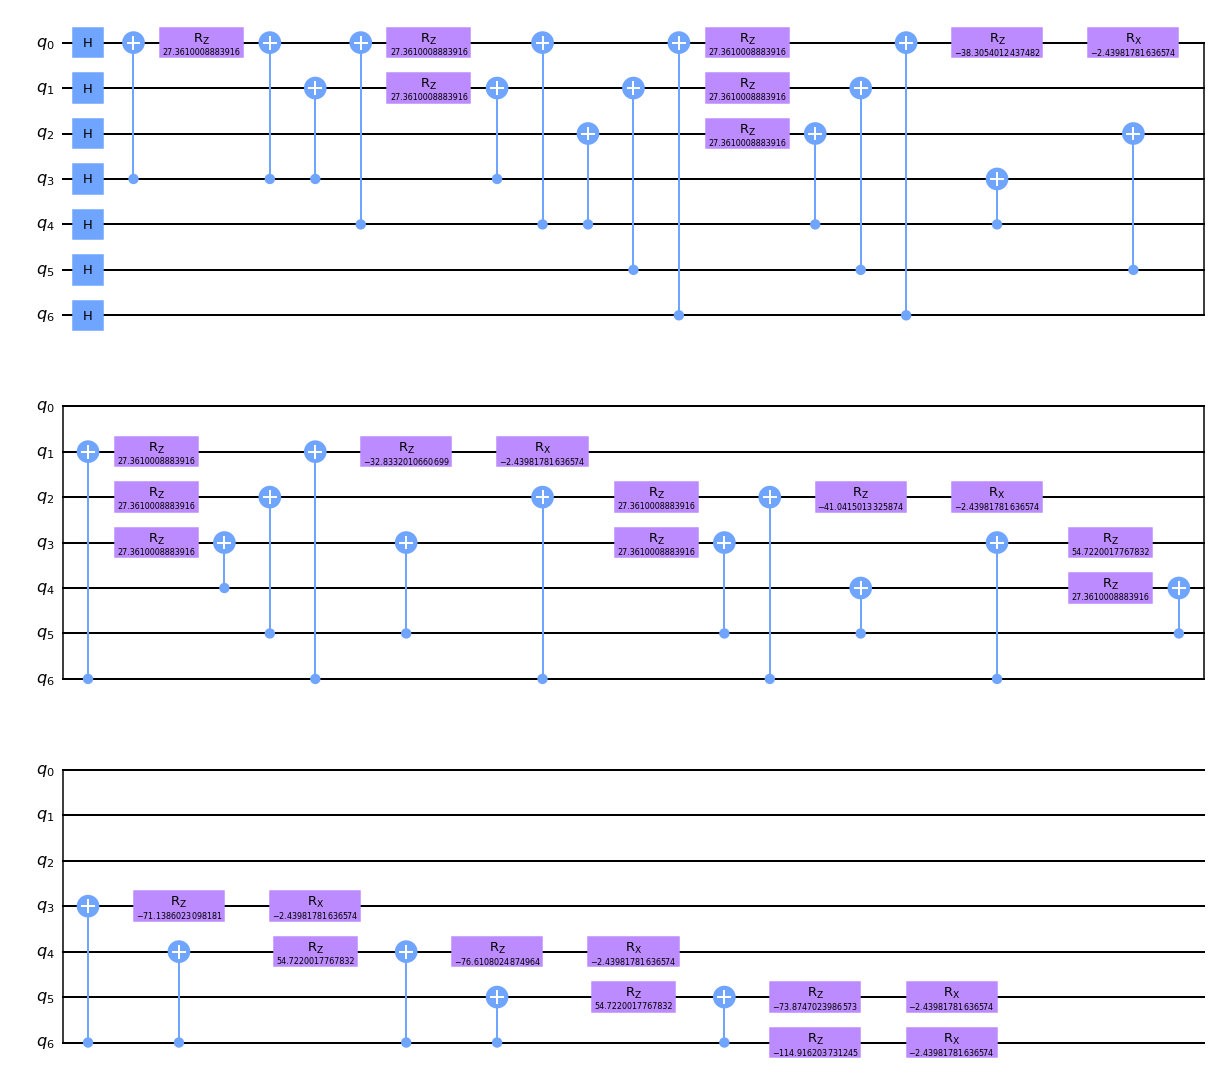

In [7]:
qaoa_mes.get_optimal_circuit().draw('mpl')

## Decode the solution

The solution from the QAOA is an array of binary digiits.
The following piece of code converts the solution of QUBO to the solution of the original CSG problem, i.e., the Optimal Coaliton Structure.

In [8]:
decode(solution, coalition_values) # A function in Utils_CSG.py

[{'2'}, {'1', '3'}]